In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sma
import warnings
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Krain\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return (np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [3]:
NVDA = pd.read_csv("NVDA.csv", index_col= ['Date'], parse_dates = ['Date'], dayfirst = True)
NVDA.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-03-31,21.410000,21.430000,20.910000,20.930000,20.380299,8931900
2015-04-01,21.010000,21.080000,20.650000,21.010000,20.458195,8228300
2015-04-02,21.129999,21.190001,20.879999,21.059999,20.506882,4805100
2015-04-06,20.969999,21.740000,20.750000,21.670000,21.100864,12896600
2015-04-07,21.670000,22.100000,21.549999,21.860001,21.285873,10349100


In [4]:
NVDA.shape

(756, 6)

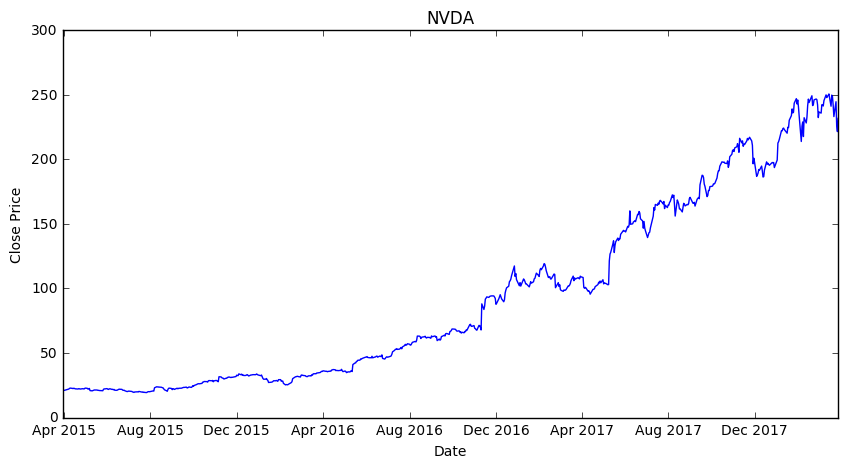

In [5]:
plt.figure(figsize=(10,5))
plt.plot(NVDA.Close)
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.title('NVDA')
plt.show()

In [6]:
difference = (NVDA.index[755] - NVDA.index[0]).days
dates_for_filling = [datetime.datetime.strptime("2015-03-31", "%Y-%m-%d") +  relativedelta(days = x) for x in range (0,difference + 1)]
for_filling = pd.DataFrame({'Col_1': np.arange(0, difference + 1)}, index= dates_for_filling )

In [7]:
NVDA = pd.merge(for_filling, NVDA, how = 'left', left_index= True, right_index= True)
del NVDA['Col_1']

In [8]:
NVDA = NVDA.ffill()

In [9]:
def make_analysis(target):
    plt.figure(figsize(15,10))
    sma.tsa.seasonal_decompose(target, freq = 12).plot()
    plt.show()
    print("Dickey Fuller's criteria: p = {}".format(sma.tsa.stattools.adfuller(target)[1]))

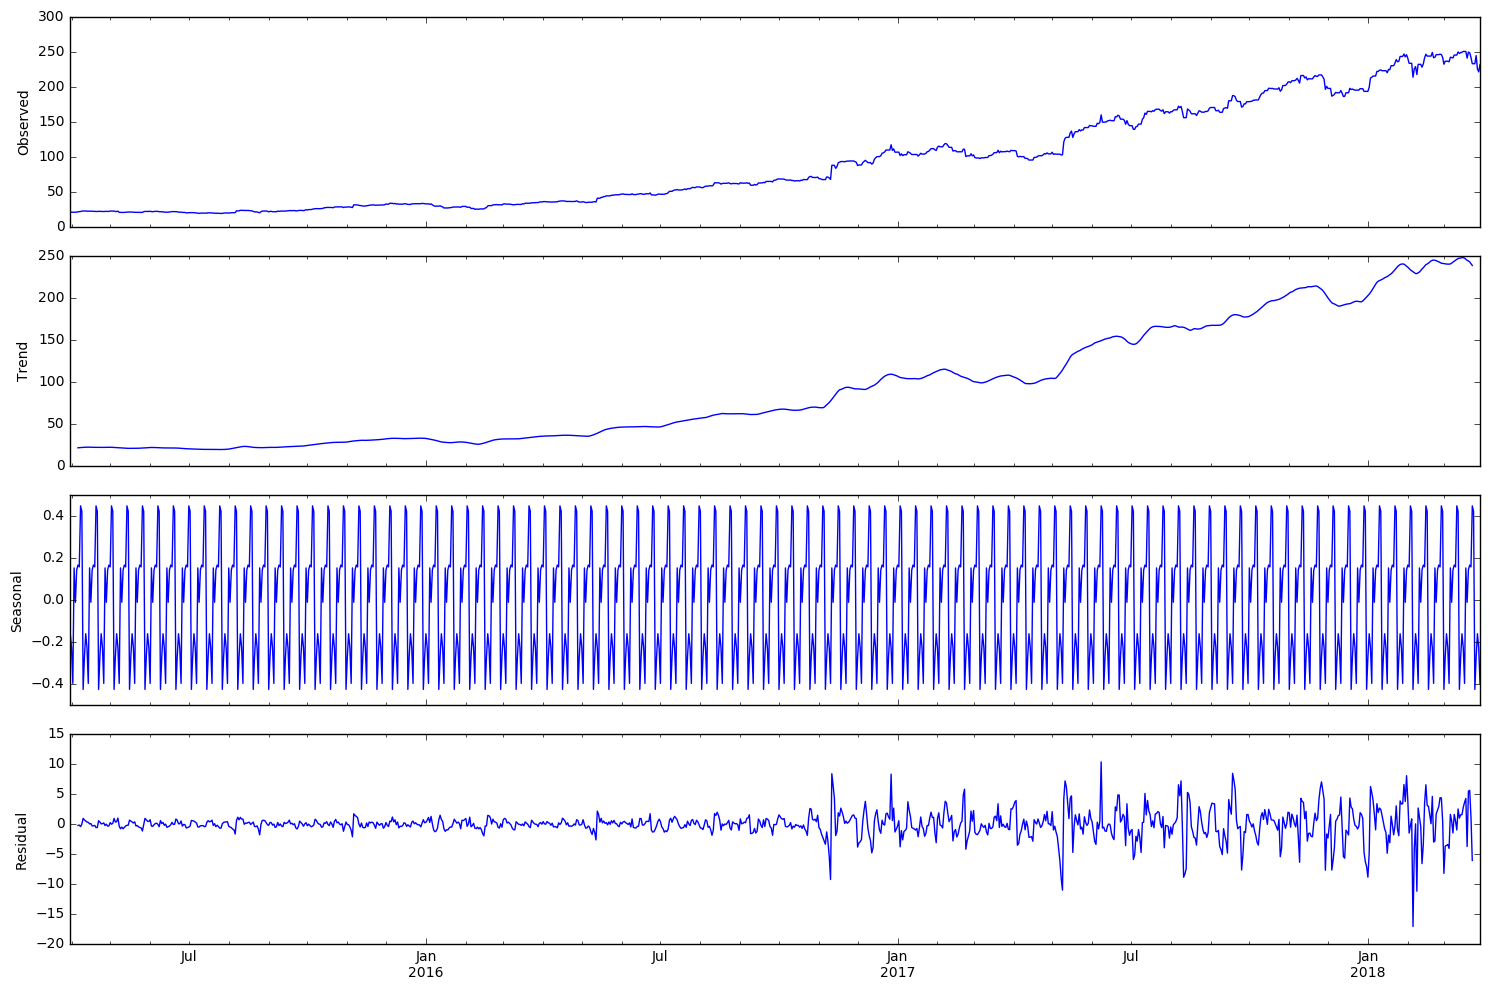

Dickey Fuller's criteria: p = 0.9963305970512082


In [10]:
make_analysis(NVDA.Close)

In [11]:
NVDA['CLOSE_BOX'], lmbda = stats.boxcox(NVDA.Close)

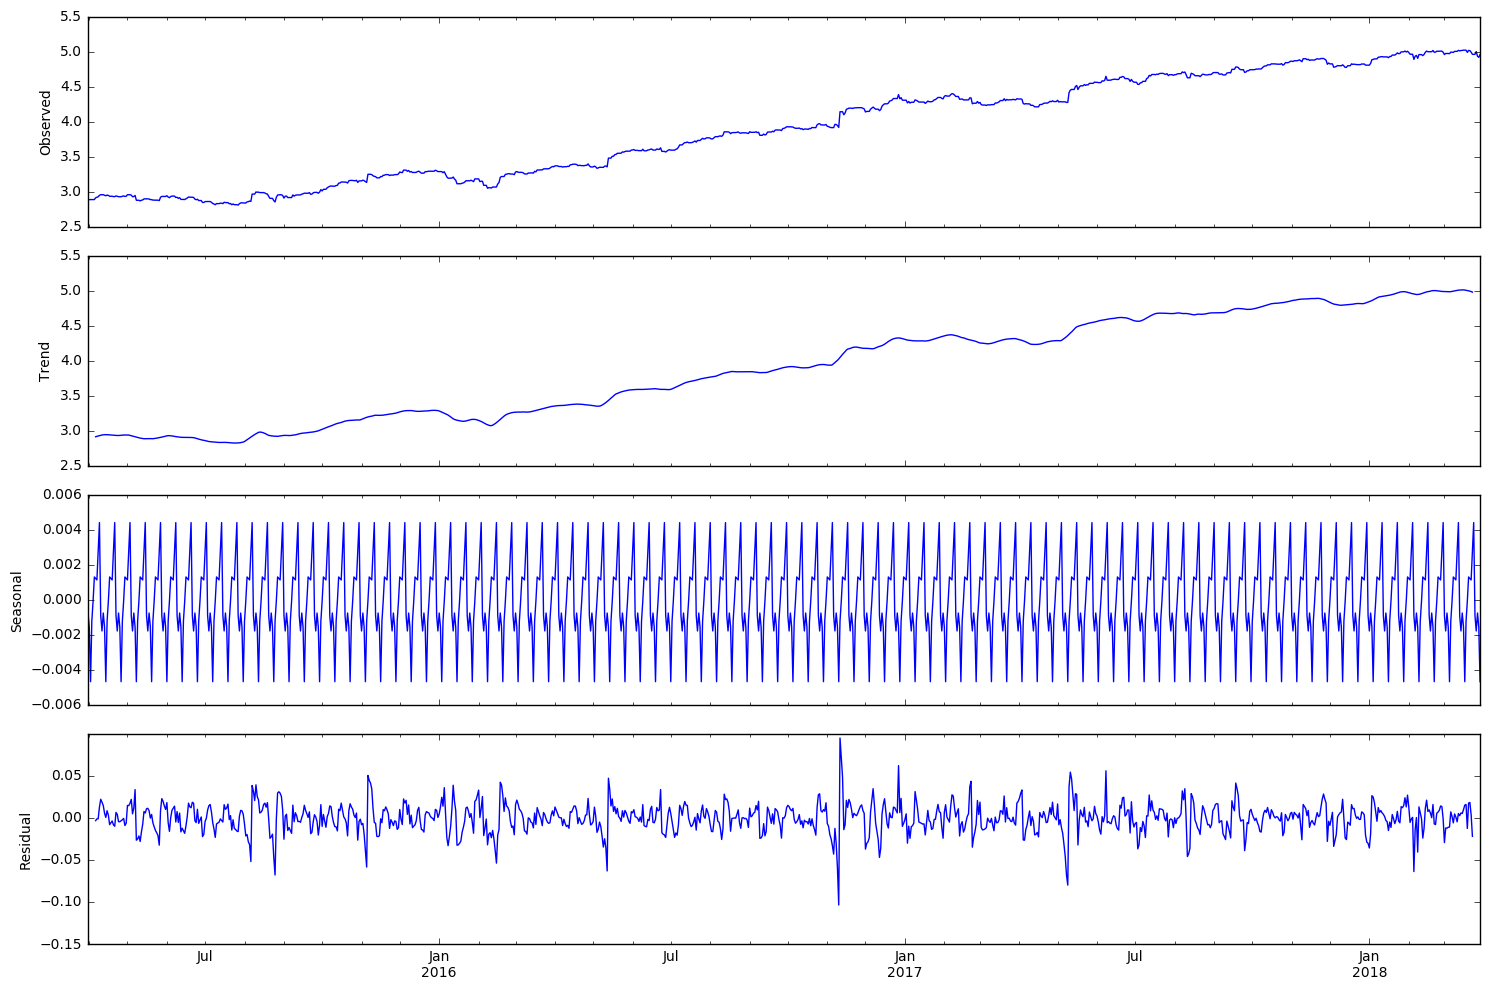

Dickey Fuller's criteria: p = 0.9279131683439865


In [12]:
make_analysis(NVDA.CLOSE_BOX)

In [13]:
NVDA['CLOSE_BOX_S_DIFFER'] = NVDA.CLOSE_BOX - NVDA.CLOSE_BOX.shift(7)

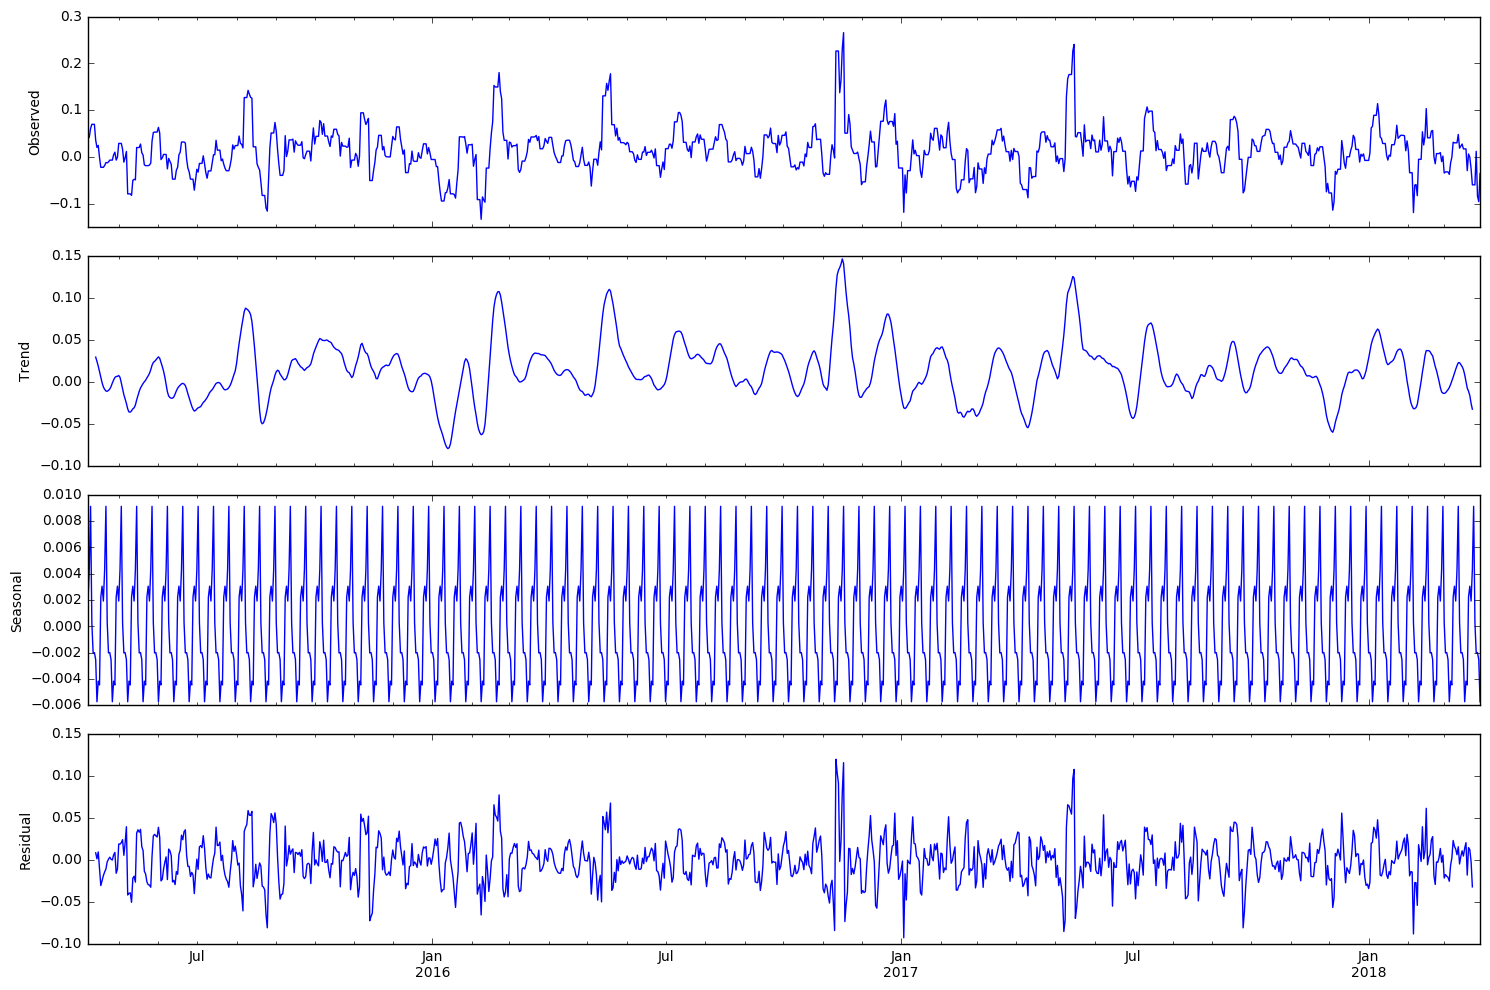

Dickey Fuller's criteria: p = 1.0932850366840535e-06


In [14]:
make_analysis(NVDA.CLOSE_BOX_S_DIFFER[7:,])

In [15]:
NVDA['CLOSE_BOX_S_C_DIFFER'] = NVDA.CLOSE_BOX_S_DIFFER - NVDA.CLOSE_BOX_S_DIFFER.shift(1)

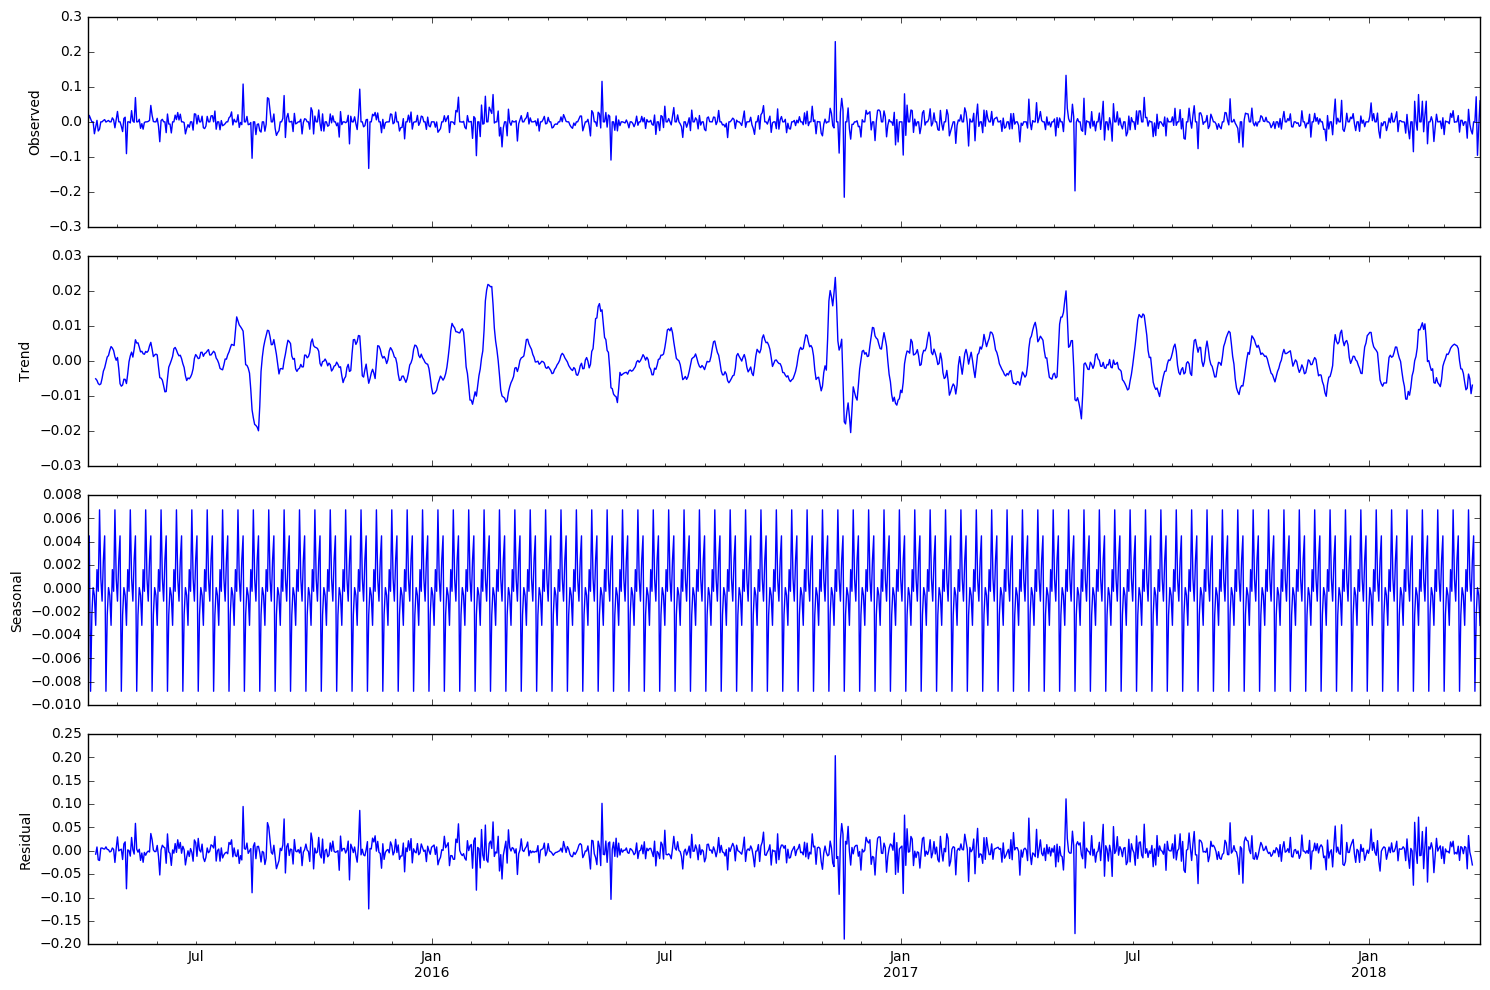

Dickey Fuller's criteria: p = 7.014480562830298e-24


In [16]:
make_analysis(NVDA.CLOSE_BOX_S_C_DIFFER[8:])

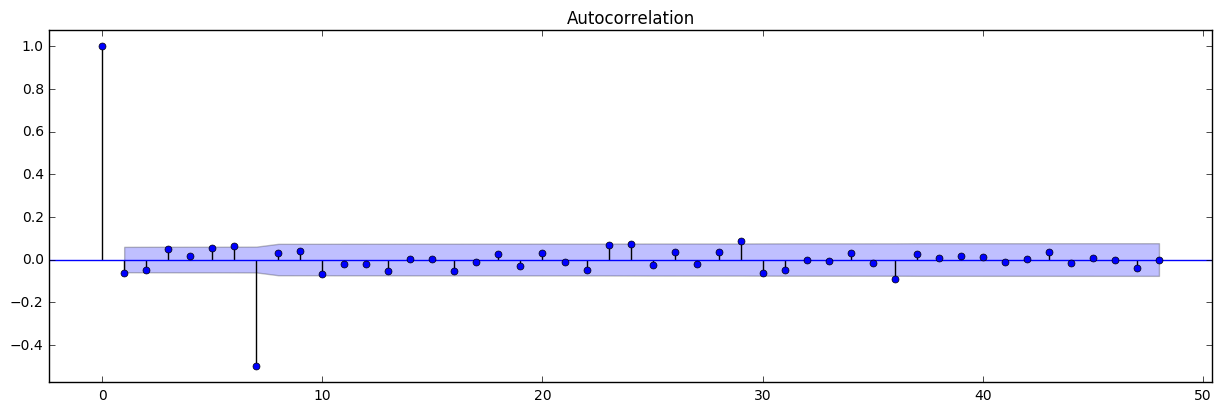

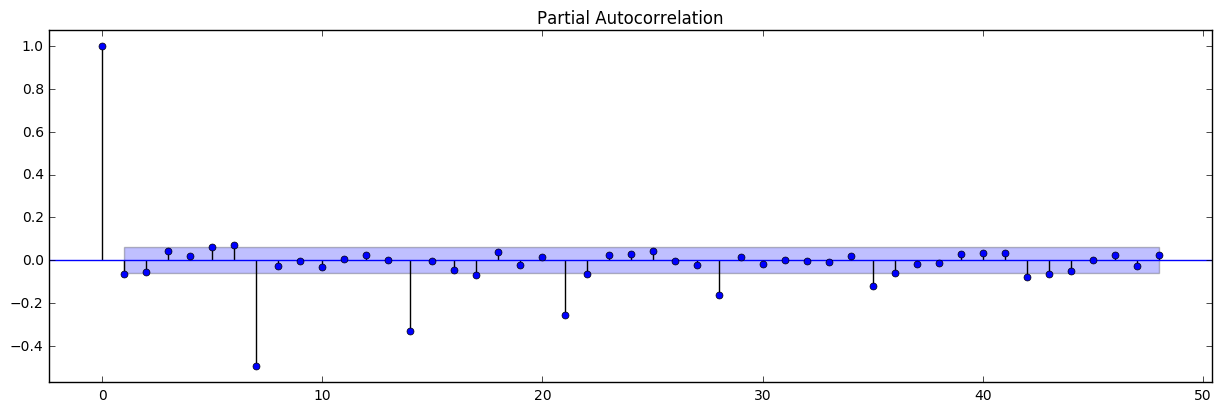

In [17]:
plt.figure(figsize(15,10))
ax = plt.subplot(211)
sma.graphics.tsa.plot_acf(NVDA.CLOSE_BOX_S_C_DIFFER[8:].values.squeeze(), lags = 48, ax = ax)
pylab.show()
ax = plt.subplot(212)
sma.graphics.tsa.plot_pacf(NVDA.CLOSE_BOX_S_C_DIFFER[8:].values.squeeze(), lags = 48, ax = ax)
pylab.show()

In [18]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 6)
D=1
Qs = range(0, 2)

In [19]:
from itertools import product

In [20]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

In [21]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sma.tsa.statespace.SARIMAX(NVDA.CLOSE_BOX, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
Wall time: 4min 28s


In [22]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending= True).head())

      parameters          aic
12  (0, 1, 0, 1) -5564.902741
24  (1, 0, 0, 1) -5564.747468
14  (0, 1, 1, 1) -5564.473289
26  (1, 0, 1, 1) -5564.337483
0   (0, 0, 0, 1) -5563.317236


In [23]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                         CLOSE_BOX   No. Observations:                 1095
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood                2785.451
Date:                           Wed, 04 Apr 2018   AIC                          -5564.903
Time:                                   22:37:52   BIC                          -5549.907
Sample:                               03-31-2015   HQIC                         -5559.229
                                    - 03-29-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0590      0.027     -2.154      0.031      -0.113      -0.005
ma.S.L7       -0.9996      0.287     -3.486

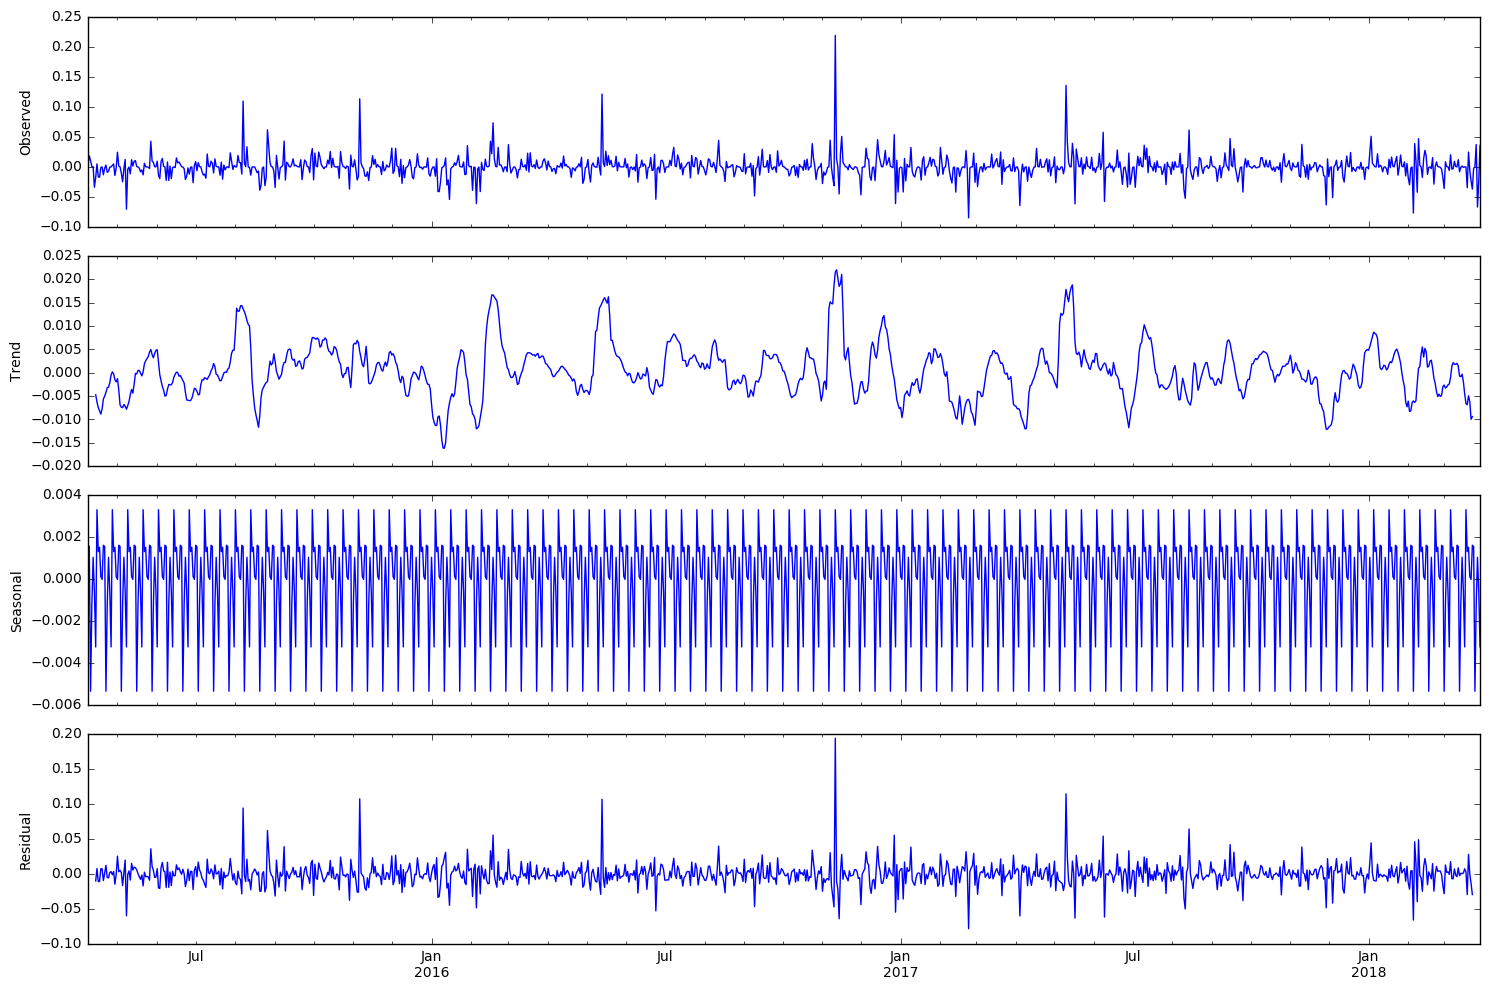

Dickey Fuller's criteria: p = 0.0
Критерий Стьюдента: p = 0.6117129330250561


In [24]:
make_analysis(best_model.resid[8:])
print("Критерий Стьюдента: p = {}".format(stats.ttest_1samp(best_model.resid[8:], 0)[1]))

In [25]:
NVDA['model'] = invboxcox(best_model.fittedvalues, lmbda)

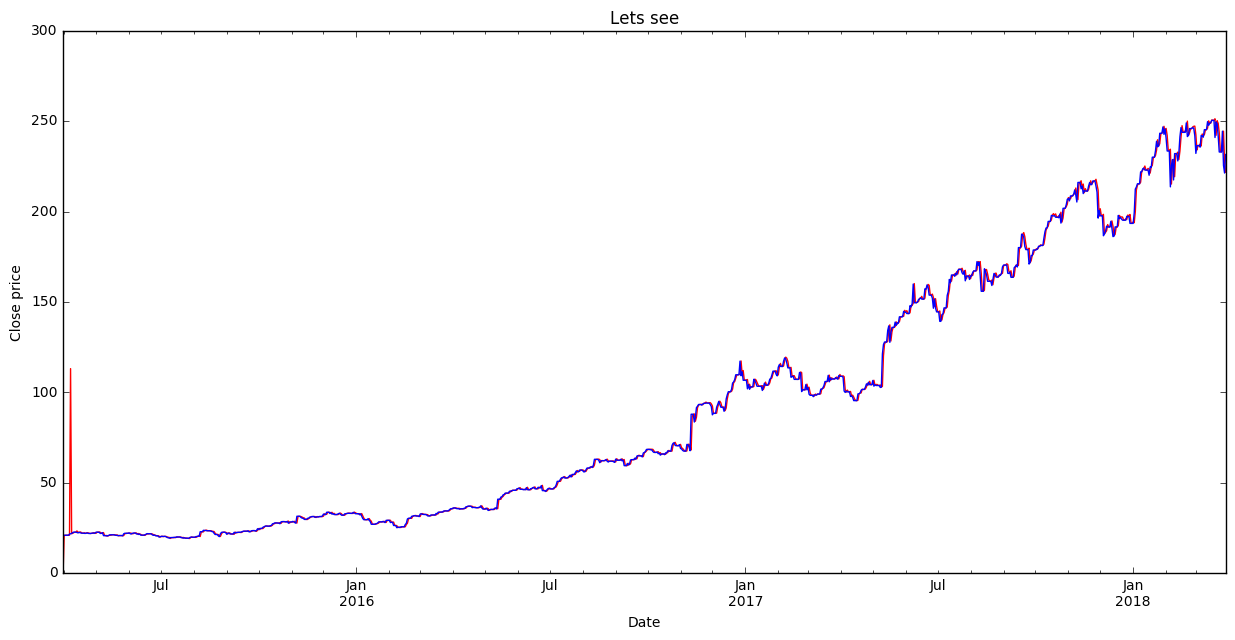

In [26]:
plt.figure(figsize(15,7))
NVDA.model.plot(color = 'R')
NVDA.Close.plot(color = 'B')
plt.title('Lets see')
plt.ylabel('Close price')
plt.xlabel('Date')
plt.show()

In [27]:
CLOSE_NEW = NVDA[['Close']]
n = 3
date_list = [datetime.datetime.strptime("2018-03-29", "%Y-%m-%d") +  relativedelta(days = x) for x in range (1,n)]
future = pd.DataFrame(index = date_list, columns = CLOSE_NEW.columns)

CLOSE_NEW = pd.concat([CLOSE_NEW, future])
CLOSE_NEW['forecast'] = invboxcox(best_model.predict(start = NVDA.shape[0], end = NVDA.shape[0] + n), lmbda)

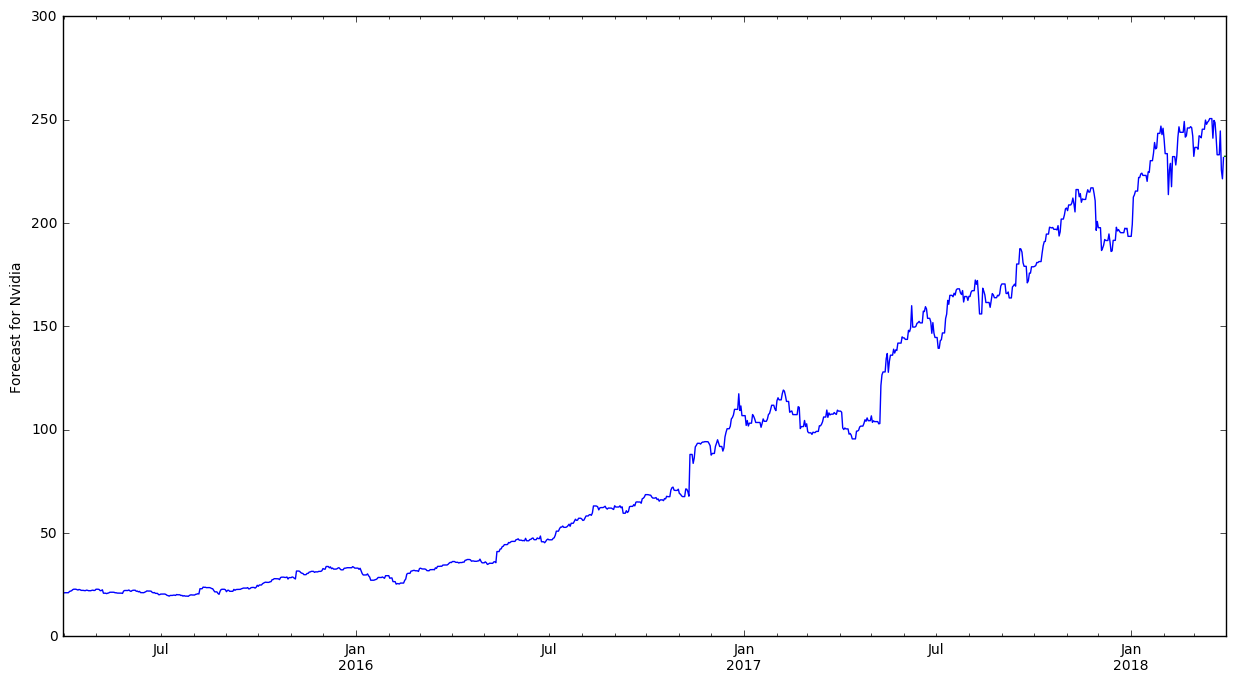

In [28]:
plt.figure(figsize(15, 8))
CLOSE_NEW.Close.plot()
CLOSE_NEW.forecast.plot(color = 'green')
plt.ylabel('Forecast for Nvidia')
pylab.show()

In [29]:
mae_of_forecast = 228.75 - CLOSE_NEW[CLOSE_NEW.index == "2018-03-30"].forecast
mae_of_forecast

2018-03-30   -3.487221
Name: forecast, dtype: float64

### Let's see the correlations between other top IT companies (which I remembered for this analysis)

In [30]:
# a little help for reading csv-s

def reader(company):
    name = company + '.csv'
    company_stock = pd.read_csv(name, index_col= ['Date'], parse_dates= ['Date'], dayfirst= True )
    return company_stock

In [31]:
# read
BTC = reader('BTC-USD')
IBM = reader('IBM')
INTL = reader('INTC')
MSFT = reader('MSFT')

In [32]:
IBM = pd.merge(for_filling, IBM, how = 'left', left_index= True, right_index= True).ffill()
del IBM['Col_1']
INTL = pd.merge(for_filling, INTL, how = 'left', left_index= True, right_index= True).ffill()
del INTL['Col_1']
MSFT = pd.merge(for_filling, MSFT, how = 'left', left_index= True, right_index= True).ffill()
del MSFT['Col_1']

In [33]:
BTC = BTC.iloc[1:1096, :]

In [34]:
MSFT.index = np.arange(0, 1095)
IBM.index = np.arange(0, 1095)
INTL.index = np.arange(0, 1095)
BTC.index = np.arange(0, 1095)

In [35]:
NVDA.index = np.arange(0, 1095)

In [36]:
aggregated = pd.DataFrame({'NVDA': NVDA.Close, 'IBM': IBM.Close, 'MSFT': MSFT.Close, 'INTL': INTL.Close, 'BTC': BTC.Close})

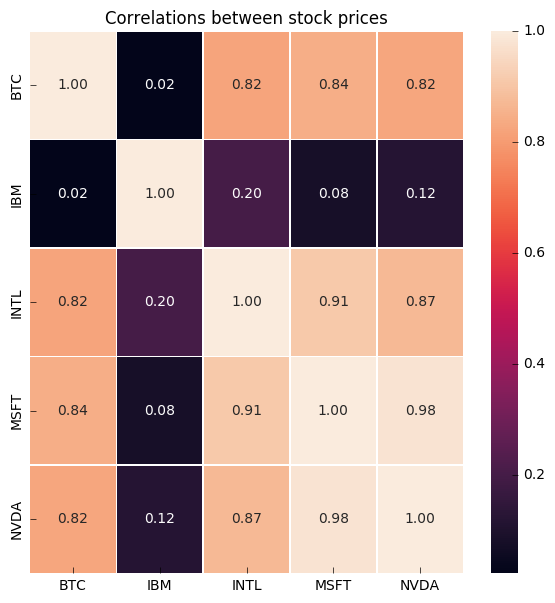

In [37]:
correlations = aggregated.corr()
plt.figure(figsize(7, 7))
sns.heatmap(correlations, linewidths=0.45, annot= True, fmt= '.2f')
plt.title('Correlations between stock prices')
plt.show()

In [38]:
from sklearn.decomposition import truncated_svd, PCA
from sklearn.linear_model import ridge_regression, Ridge
from sklearn.preprocessing import StandardScaler 

In [39]:
pca = PCA(n_components= 4)

In [40]:
aggregated.head()

,BTC,IBM,INTL,MSFT,NVDA
0,246.240005,160.500000,31.270000,40.660000,20.930000
1,252.600006,159.179993,30.809999,40.720001,21.010000
2,254.479996,160.449997,30.809999,40.290001,21.059999
3,252.889999,160.449997,30.809999,40.290001,21.059999
4,259.640015,160.449997,30.809999,40.290001,21.059999


In [41]:
pca.fit(aggregated.iloc[:,0:4])

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [42]:
var = pca.explained_variance_ratio_.round(6)

In [43]:
var_for_graph = 100 * np.cumsum(var)

In [44]:
var_for_graph

array([  99.9985,   99.9996,  100.    ,  100.    ])

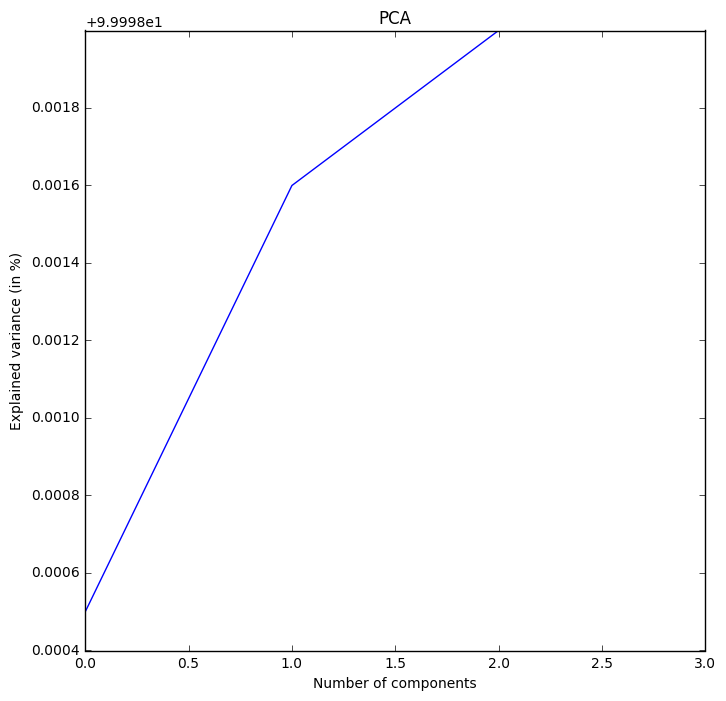

In [45]:
plt.figure(figsize(8,8))
plt.title('PCA')
plt.ylabel('Explained variance (in %)')
plt.xlabel('Number of components')
plt.plot(var_for_graph)
plt.show()

In [46]:
integral_stock_component = pca.fit_transform(aggregated)

In [47]:
integral_stock_component = pd.DataFrame(integral_stock_component)
integral_stock_component.columns = ['1c', '2c', '3c', '4c']

In [48]:
print("correlation between 1st component and stock price of NVDA: {}".format(round(np.corrcoef(integral_stock_component['1c'], NVDA.Close)[0][1], 4)))

correlation between 1st component and stock price of NVDA: 0.8245


### Let's make model with CV on NVDA and make forecast (for other companies too)

In [49]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [50]:
split_date = '2018-03-01'

In [51]:
NVDA.index =  for_filling.index

In [52]:
aggregated.index = for_filling.index

In [53]:
Y = aggregated.NVDA
X = aggregated
del X['NVDA']
del X['BTC']

In [54]:
y_train = Y[Y.index < split_date]
X_train = X[X.index < split_date]

y_test = Y[Y.index >= split_date]
X_test = X[X.index >= split_date]

In [55]:
c = (np.power(10.0, np.arange(-5, 5))).tolist()

In [56]:
result = []
for i in c:
    clf = Ridge(alpha= i)
    results = cross_val_score(estimator= clf, scoring= 'neg_mean_absolute_error', X=X, y=Y, cv= TimeSeriesSplit(n_splits= 30))
    result.append(results.mean())

In [57]:
np.argmin(result), results[np.argmin(result)], c[np.argmin(result)] 

(9, -9.0264331266824147, 10000.0)

In [59]:
model = Ridge(alpha = c[np.argmin(result)])

In [60]:
model.fit(X_train, y_train)

Ridge(alpha=10000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [61]:
prediction_ridge = model.predict(X_test)

In [62]:
from sklearn.metrics import mean_absolute_error as mae , mutual_info_score, median_absolute_error

In [63]:
mae(y_pred= prediction_ridge, y_true=y_test)

7.2146457496517185

In [64]:
# the same for component
from sklearn.linear_model import LinearRegression

In [65]:
integral_stock_component = integral_stock_component['1c']

In [66]:
component_train = integral_stock_component.iloc[:1066,]
component_test = integral_stock_component.iloc[1066:,]

In [67]:
component_model = LinearRegression()

In [68]:
component_model.fit(component_train.reshape(-1,1), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [69]:
component_prediction = component_model.predict(component_test.reshape(-1,1))

In [70]:
mae(y_true = y_test, y_pred = component_prediction)

51.340164792486043

In [73]:
# Лучше выбрать регулиризованную модель

####  Однако дальше будем пробовать бустинг над решающими деревьями для модели и учтем 3 компании и биткоин

In [74]:
import lightgbm as lgbt

C:\Users\Krain\Anaconda3\lib\site-packages\lightgbm\__init__.py:27: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:\\Users\\Krain\\Anaconda3\\lib\\site-packages\\lightgbm\\VERSION.txt' mode='r' encoding='cp1251'>
  __version__ = open(os.path.join(dir_path, 'VERSION.txt')).read().strip()


## нагенерить фичи по всему возможному (день недели, выходной-нет, месяц, год, сезон, лаги до 2-5 порядка, аналогично по остальным акциям)
## + добавить цены закрытия и отношения
#### to be continued

In [563]:
Y = NVDA.Close
Y_train = Y[Y.index < split_date]
Y_test = Y[Y.index >= split_date]

In [564]:
X_train = Y_train.index
X_test = Y_test.index

In [565]:
Y_train.index = np.arange(0, Y_train.shape[0])
Y_test.index = np.arange(0, Y_test.shape[0])

In [566]:
train_data = lgbt.Dataset(X_train, label = Y_train)
test_data = lgbt.Dataset(X_test, label = Y_test)

In [560]:
params = {'num_leaves':4, 'num_trees':30000, 'lambda_l1': 50, "min_data_in_leaf": 10,  "sigmoid" : 2,
    'boosting': 'gbdt', 'objective':'binary', "learning_rate": 0.01, "num_threads": 2, "max_depth": 2, "min_child_weight" : 4}
params['metric'] = 'mae'

In [567]:
lgbt_model = lgbt.train(params, train_data, valid_sets=[Y], num_boost_round=30000, early_stopping_rounds= 50 )

C:\Users\Krain\Anaconda3\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


TypeError: Traninig only accepts Dataset object

In [569]:
train_data.data

DatetimeIndex(['2015-03-31', '2015-04-01', '2015-04-02', '2015-04-03',
               '2015-04-04', '2015-04-05', '2015-04-06', '2015-04-07',
               '2015-04-08', '2015-04-09',
               ...
               '2018-02-19', '2018-02-20', '2018-02-21', '2018-02-22',
               '2018-02-23', '2018-02-24', '2018-02-25', '2018-02-26',
               '2018-02-27', '2018-02-28'],
              dtype='datetime64[ns]', length=1066, freq=None)